In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import patheffects
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [2]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [3]:
# Open NCEP GFS dataset; change name accordingly to yours
ds = xr.open_dataset('US_SYNOPTIC/081416_0600H.f00.nc4')
ds

<xarray.Dataset>
Dimensions:                                            (sigma: 1,
                                                        potential_vorticity_surface: 2,
                                                        latitude: 101,
                                                        isobaric3: 31,
                                                        height_above_ground1: 3,
                                                        isobaric1: 21, time: 1,
                                                        height_above_ground3: 1,
                                                        longitude: 141,
                                                        isobaric4: 26)
Coordinates:
  * sigma                                              (sigma) float64 0.995
    reftime                                            datetime64[ns] ...
  * potential_vorticity_surface                        (potential_vorticity_surface) float64 ...
  * latitude                                           (latitude) float32 25....
  * isobaric3                                          (isobaric3) float64 10...
  * height_above_ground1                               (height_above_ground1) float64 ...
  * isobaric1                                          (isobaric1) float64 1e...
  * time                                               (time) datetime64[ns] ...
  * height_above_ground3                               (height_above_ground3) float64 ...
  * longitude                                          (longitude) float32 10...
  * isobaric4                                          (isobaric4) float64 1e...
Data variables: (12/18)
    Vertical_velocity_pressure_isobaric                (time, isobaric1, latitude, longitude) float32 ...
    Relative_humidity_isobaric                         (time, isobaric3, latitude, longitude) float32 ...
    Temperature_isobaric                               (time, isobaric3, latitude, longitude) float32 ...
    v-component_of_wind_sigma                          (time, sigma, latitude, longitude) float32 ...
    v-component_of_wind_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    u-component_of_wind_height_above_ground            (time, height_above_ground1, latitude, longitude) float32 ...
    ...                                                 ...
    u-component_of_wind_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    Dewpoint_temperature_height_above_ground           (time, height_above_ground3, latitude, longitude) float32 ...
    u-component_of_wind_sigma                          (time, sigma, latitude, longitude) float32 ...
    Vertical_velocity_pressure_sigma                   (time, sigma, latitude, longitude) float32 ...
    Geopotential_height_isobaric                       (time, isobaric3, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E                      int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                         

In [4]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
geop = ds['Geopotential_height_isobaric'] 
uwnd = ds['u-component_of_wind_isobaric']
vwnd = ds['v-component_of_wind_isobaric']
temp = ds['Temperature_isobaric']

# Select and grab 850-hPa geopotential heights, boundary-layer temps,
# and wind components, smooth with gaussian_filter
temp_850 = gaussian_filter(temp.sel(isobaric3=85000).data[0], sigma=3.0) * units.kelvin
hght_850 = gaussian_filter(geop.sel(isobaric3=85000).data[0], sigma=3.0) * units('m')
hght_850dm = hght_850.to(units.decameter)

uwnd_850 = gaussian_filter(uwnd.sel(isobaric3=85000).data[0], sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(vwnd.sel(isobaric3=85000).data[0], sigma=3.0) * units('m/s')

# Temperature to degree Celcius
tempc_850 = temp_850.to('degC')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

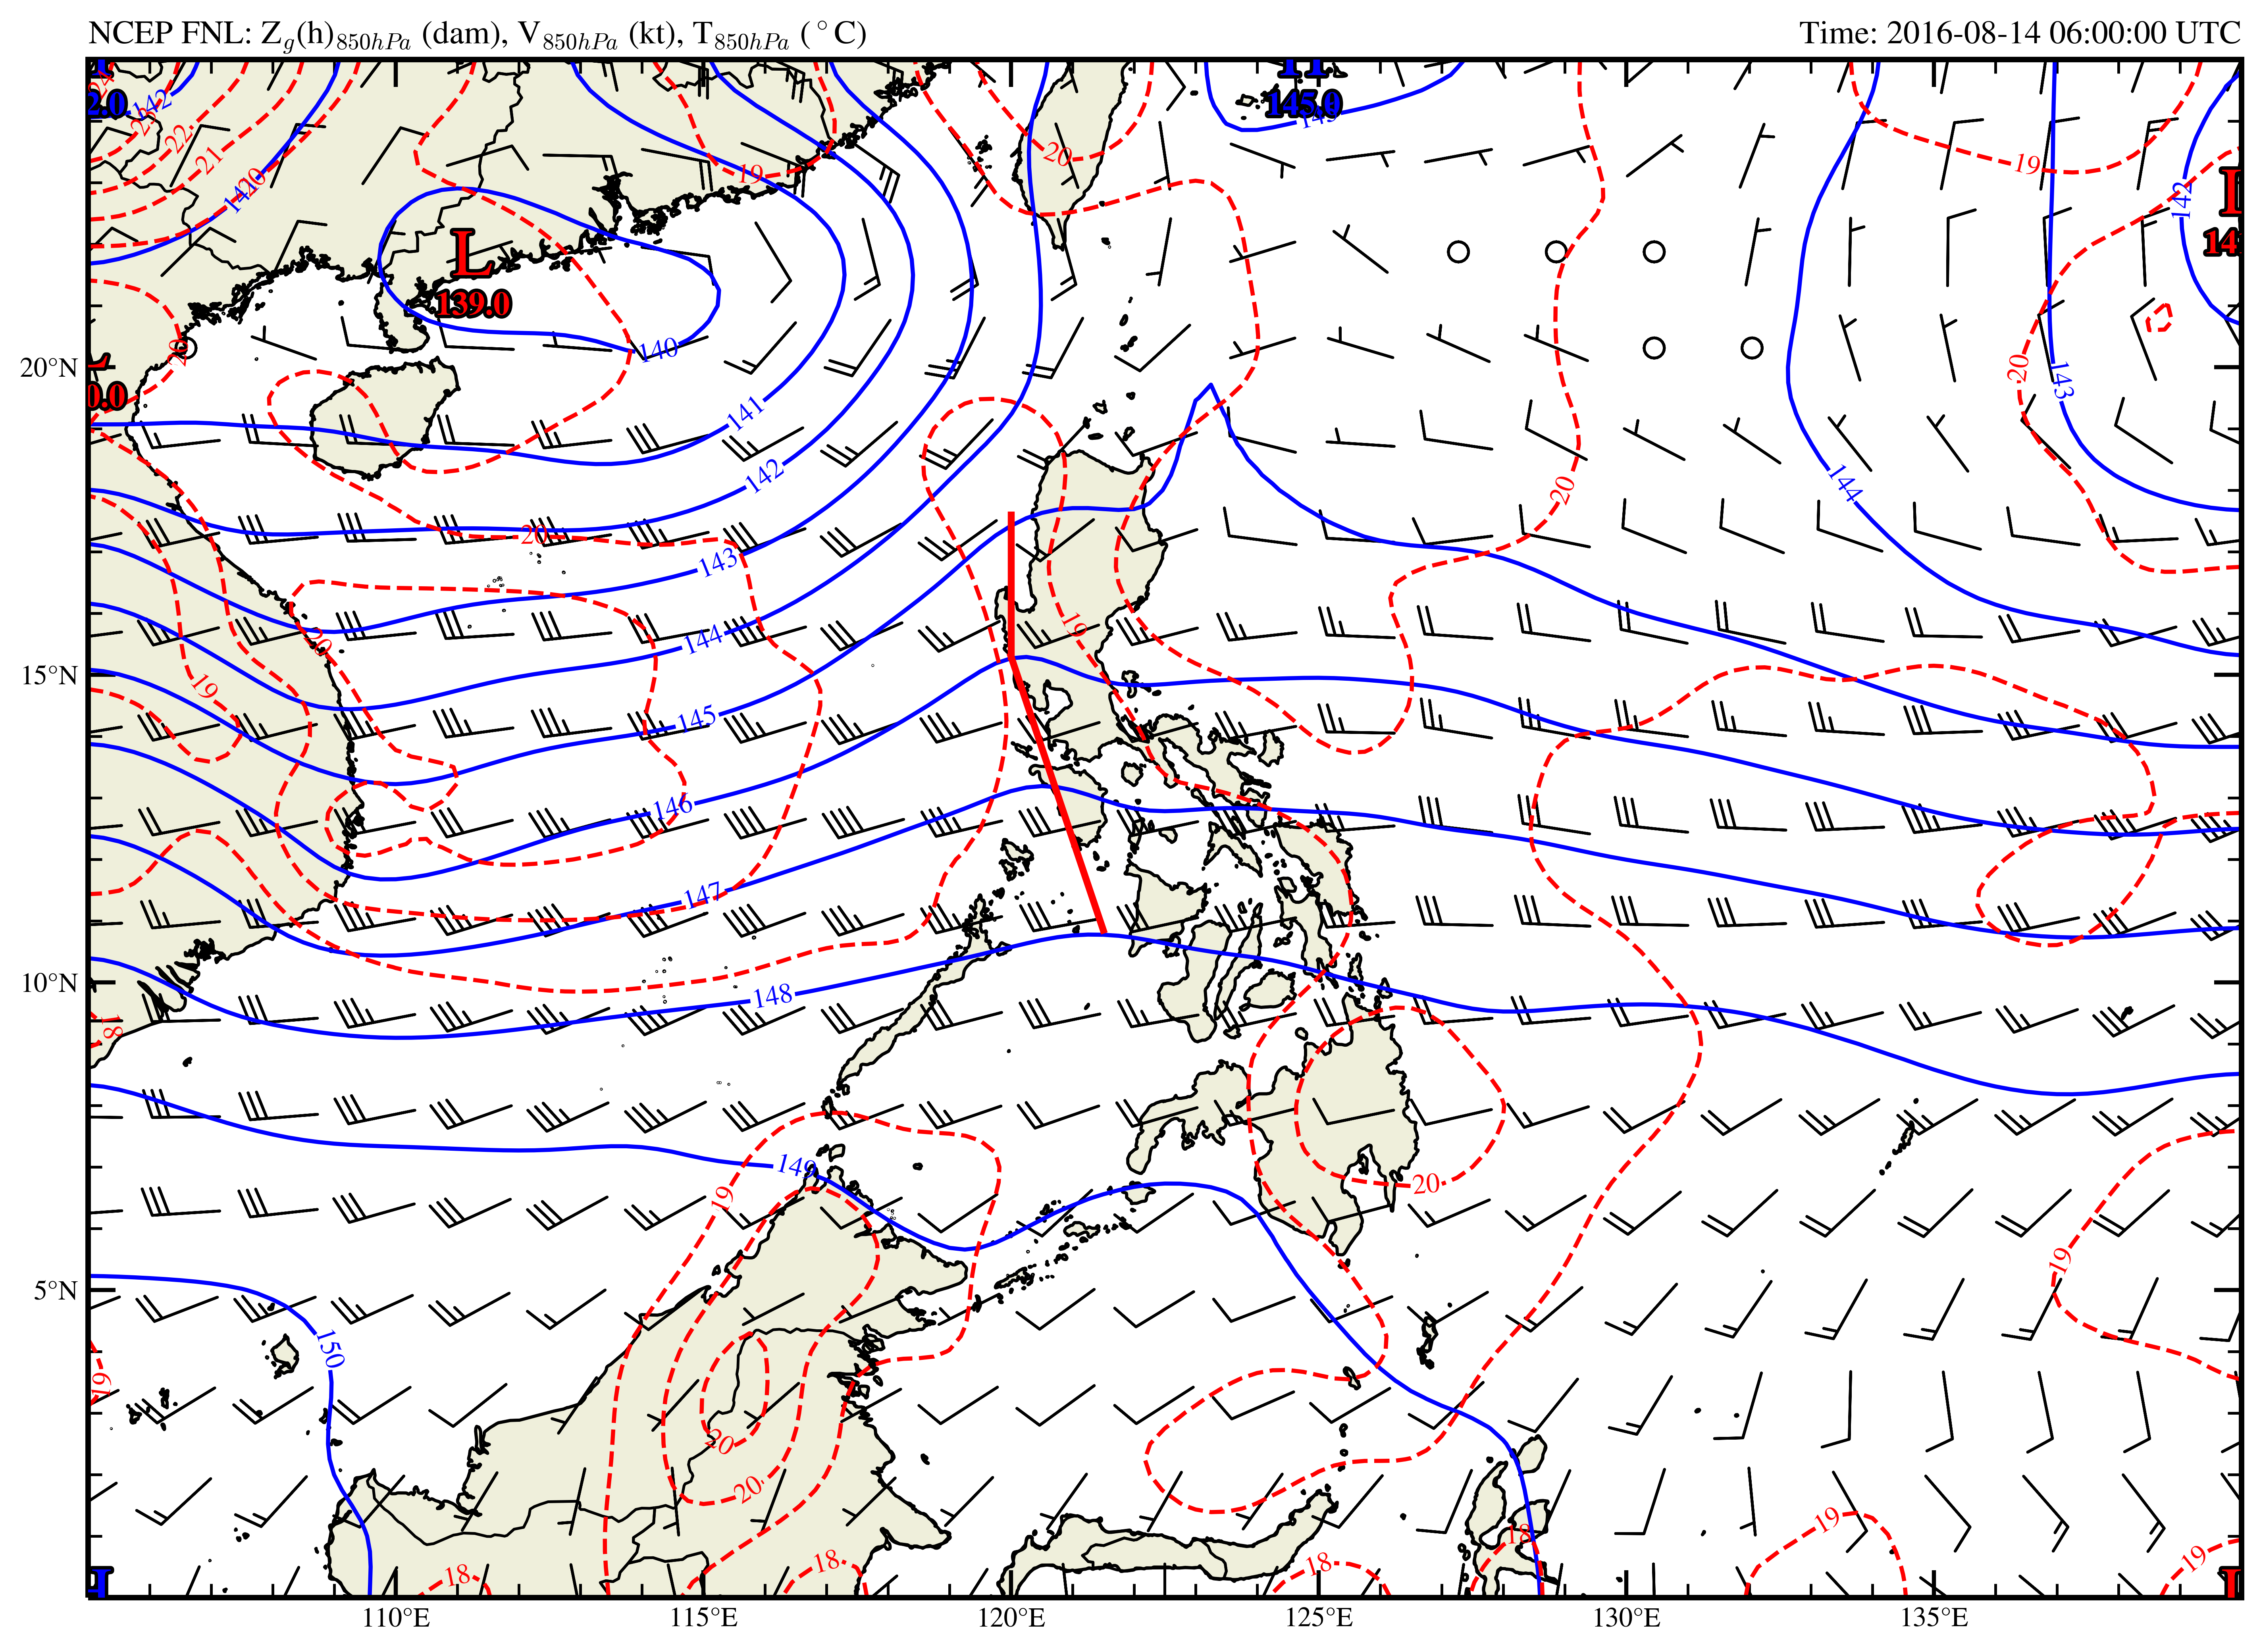

In [10]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries and earth feature for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'], zorder=1)
ax.add_feature(land_10m)

# Plot 850-hPa Geopotential Heights in dam
clevs_850_hght = np.arange(140, 151, 1)
cs = ax.contour(lons, lats, hght_850dm, clevs_850_hght, colors='blue',
                transform=datacrs)
ax.clabel(cs, fmt='%d')

# Plot 850-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_850.to('kt').m, vwnd_850.to('kt').m, pivot='middle',
         color='black', regrid_shape=17, transform=datacrs)

# Plot 850-hPa/Boundary-layer Temperature
csf = ax.contour(lons, lats, tempc_850, colors='red',
                 linestyles='dashed', transform=datacrs)
ax.clabel(csf, fmt='%d')

# Plot Highs and Lows (Min/Max) values of Geopotential Height
plot_maxmin_points(lons, lats, hght_850dm, 'max', 40, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, hght_850dm, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('NCEP FNL: Z$_{g}$(h)$_{850hPa}$ (dam), V$_{850hPa}$ (kt), T$_{850hPa}$ ($^\circ$C)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Create a/the line(s) that highlights the 850-hPa trough
point1 = dict(lon=120.00, lat=17.60)
point2 = dict(lon=120.00, lat=15.30)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', linewidth=2.5, transform=ccrs.Geodetic())

point3 = dict(lon=120.00, lat=15.30)
point4 = dict(lon=121.50, lat=10.85)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', linewidth=2.5, transform=ccrs.Geodetic())

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('GPM, Winds, Temps.jpg', bbox_inches="tight")
plt.show()